In [129]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pprint import pprint
from scipy.interpolate import interp1d
from multiprocessing import Pool

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
np.set_printoptions(precision=3)
np.seterr(*(['ignore']*5))

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
def format_figure(figure=None, axs=None, size_x=15, size_y=10, legend=False, equal_aspect=False, fontsize=16, cb=None, cblabel='', legend_fontsize=16, loc=0):
    if figure == None:
        figure = plt.gcf()
    if np.all(axs == None):
        axs = [plt.gca()]
    figure.set_size_inches(size_x, size_y)
    
    for ax in np.reshape(axs, -1):
        if legend:
            ax.legend(fontsize=legend_fontsize, loc=loc)
        
        if equal_aspect:
            ax.set_aspect('equal')
        
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    
    if cb:
        if cblabel:
            cb.set_label(cblabel, legend_fontsize=fontsize)
        
        cb.ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()

In [132]:
filenames = natsorted(glob('data/weig*.csv'))
pprint(filenames)

['data/weighted_1400_801_0.003384_0.050317_0.079917_0.969072.csv',
 'data/weighted_1400_801_0.243909_2.719421_0.743368_0.677017.csv',
 'data/weighted_1400_801_0.370089_-0.052649_-1.285518_0.651621.csv',
 'data/weighted_5120_2881_1.089792_-0.665961_-0.179857_0.011361.csv',
 'data/weighted_5120_2881_1.417164_-0.710342_-0.229364_0.001623.csv']


In [136]:
i = 2
tmp = 'data/*' + filenames[i].split('.')[-2] + '*.csv'
print(tmp)
fns = natsorted(glob(tmp))
data = np.array([np.loadtxt(fn, dtype=int, comments=None, delimiter=',') for fn in fns])

data/*651621*.csv


In [137]:
data.shape

(5, 801, 1400)

In [138]:
def normalizeHist(ar, bins=1000, verbose=True):
    h, b = np.histogram(np.sqrt(1+ar), bins=bins)
#     b = (b[1:] + b[:-1]) / 2
    h = np.concatenate(([0], h))
    h = h.astype(np.float64) / np.sum(h)
    
    if verbose:
        plt.plot(b, np.cumsum(h), label='before')
    #     plt.yscale('log')
        format_figure()
        plt.show()
    
    f = interp1d(b, np.cumsum(h))
    
    if verbose:
        print(np.min(b), np.max(b))
        print(np.min(np.log(1+ar)), np.max(np.log(1+ar)))
    
    normAr = f(np.sqrt(1+ar))
    
    if verbose:
        h, b = np.histogram(normAr, bins=bins)
        b = (b[1:] + b[:-1]) / 2
        h = h.astype(np.float64) / np.sum(h)

        plt.plot(b, np.cumsum(h), label='after')
        format_figure()
    
    return normAr

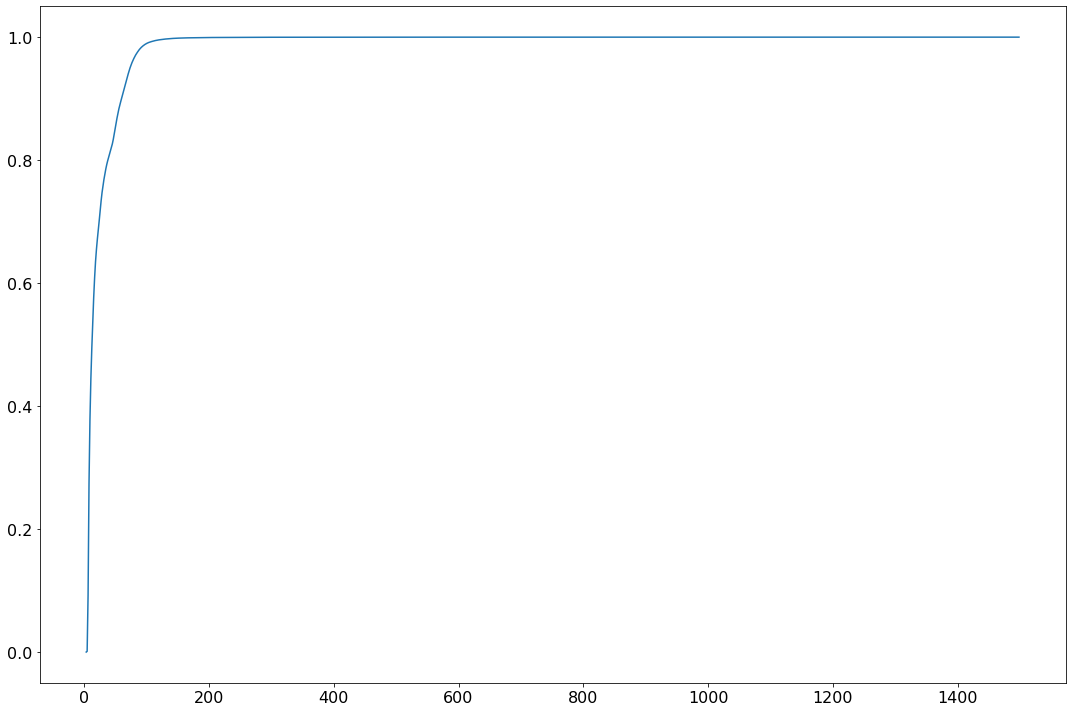

3.1622776601683795 1498.3734514466012
2.302585092994046 14.624270866076369


ValueError: too many values to unpack (expected 2)

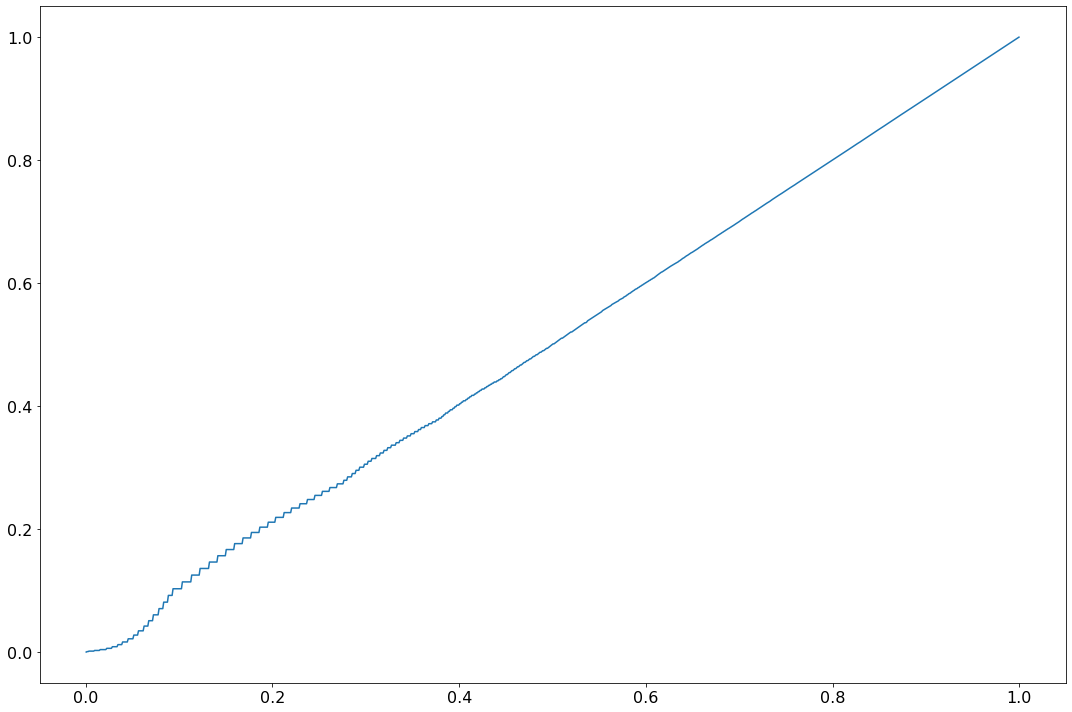

In [139]:
normF, normAr = normalizeHist(data[0])

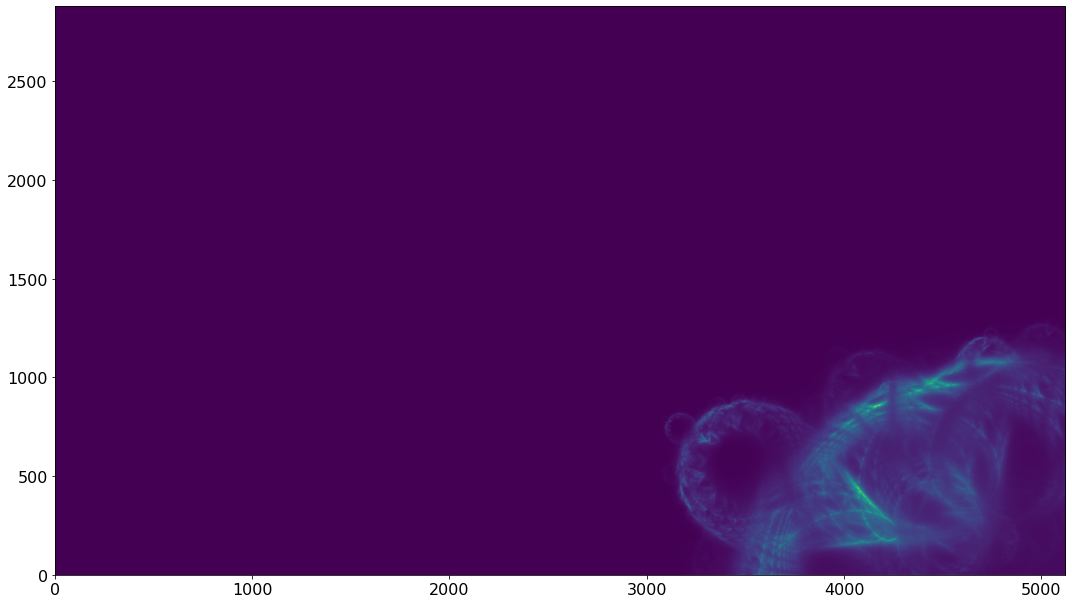

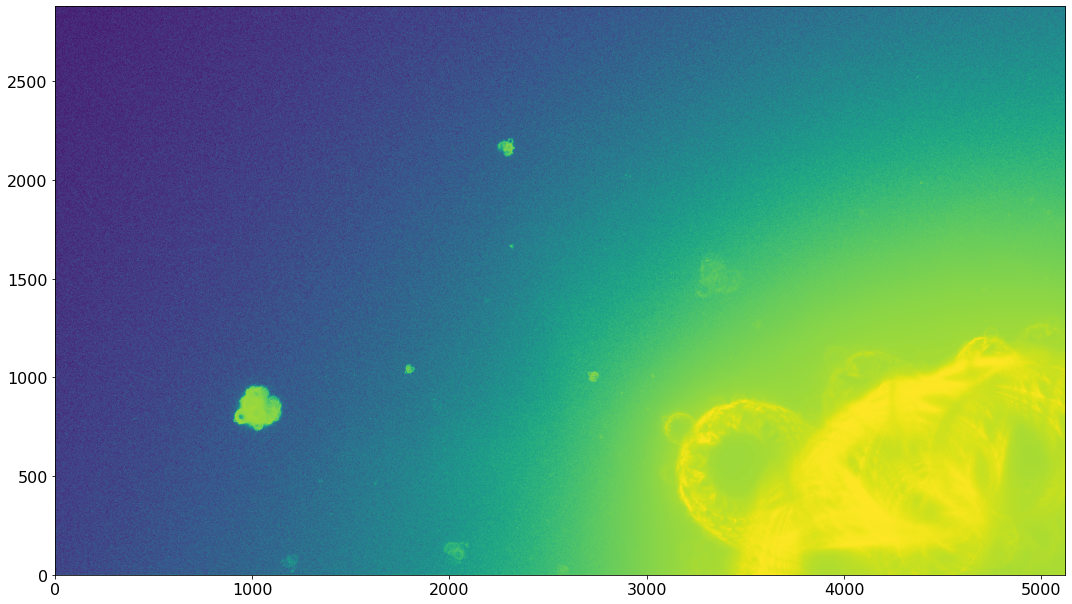

In [35]:
plt.imshow(data[0], origin='lower')
format_figure()
plt.show()

plt.imshow(normAr, origin='lower')
format_figure()
plt.show()

In [63]:
xsize = 401
ysize = 401

inp = data[0]
out = np.zeros_like(data[0], dtype=float)
weights = np.zeros_like(data[0], dtype=float)
kernel = np.dot(
    np.exp(-np.linspace(-2,2,xsize)**2).reshape(-1,1),
    np.exp(-np.linspace(-2,2,ysize)**2).reshape(1,-1)
)

xmin = 0
while xmin < out.shape[0]:
    ymin = 0
    while ymin < out.shape[1]:
#         print("normalizing block (%d, %d)" % (xmin, ymin))
        block = inp[xmin:xmin+xsize,ymin:ymin+ysize]
        nblock = normalizeHist(block, verbose=False)
        out[xmin:xmin+xsize,ymin:ymin+ysize] += nblock# * kernel[:nblock.shape[0],:nblock.shape[1]] * np.average(block)
#         weights[xmin:xmin+xsize,ymin:ymin+ysize] += np.average(block)
        ymin += int(ysize / 8)
    xmin += int(xsize / 8)

# out /= weights

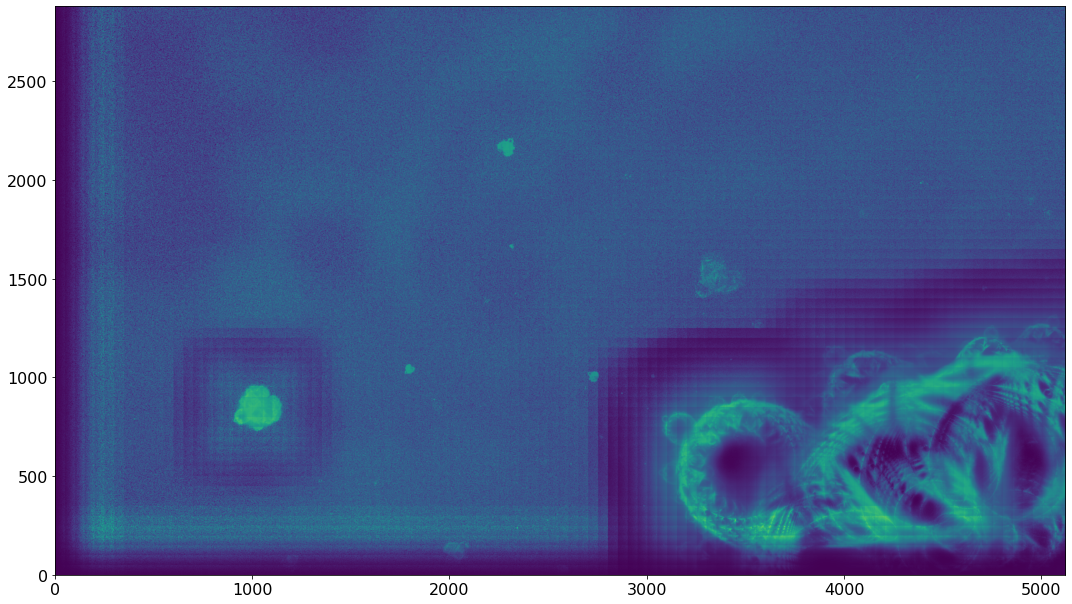

In [62]:
plt.imshow(out, origin='lower')
format_figure()

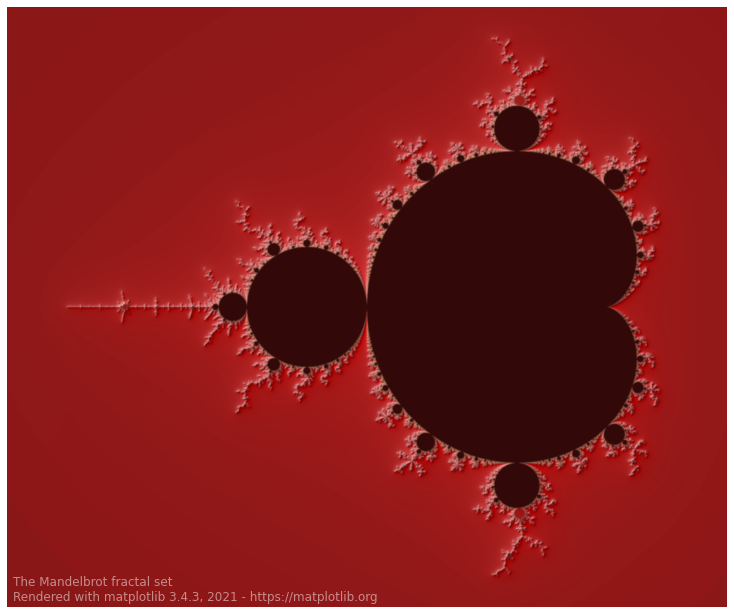

CPU times: user 4min 26s, sys: 37.7 s, total: 5min 4s
Wall time: 5min 8s


In [201]:
%%time

def mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    X = np.linspace(xmin, xmax, xn).astype(np.float32)
    Y = np.linspace(ymin, ymax, yn).astype(np.float32)
    C = X + Y[:, None] * 1j
    N = np.zeros_like(C, dtype=int)
    Z = np.zeros_like(C)
    for n in range(maxiter):
        I = abs(Z) < horizon
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N


if __name__ == '__main__':
    import time
    import matplotlib
    from matplotlib import colors
    import matplotlib.pyplot as plt

    xmin, xmax, xn = -2.25, +0.75, 3000 * 2
    ymin, ymax, yn = -1.25, +1.25, 2500 * 2
    maxiter = 2000
    horizon = 2.0 ** 10
    log_horizon = np.log2(np.log(horizon))
    Z, N = mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)
    Z, N = mandelbrot_set2(XX, YY, maxiter, horizon)

    # Normalized recount as explained in:
    # https://linas.org/art-gallery/escape/smooth.html
    # https://web.archive.org/web/20160331171238/https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en

    # This line will generate warnings for null values but it is faster to
    # process them afterwards using the nan_to_num
    with np.errstate(invalid='ignore'):
        M = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)

    dpi = 72
    width = 10
    height = 10*yn/xn
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)

    # Shaded rendering
    light = colors.LightSource(azdeg=315, altdeg=10)
    M = light.shade(M, cmap=plt.cm.hot, vert_exag=1.5,
                    norm=colors.PowerNorm(0.3), blend_mode='hsv')
    ax.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
    ax.set_xticks([])
    ax.set_yticks([])

    # Some advertisement for matplotlib
    year = time.strftime("%Y")
    text = ("The Mandelbrot fractal set\n"
            "Rendered with matplotlib %s, %s - https://matplotlib.org"
            % (matplotlib.__version__, year))
    ax.text(xmin+.025, ymin+.025, text, color="white", fontsize=12, alpha=0.5)

    plt.show()

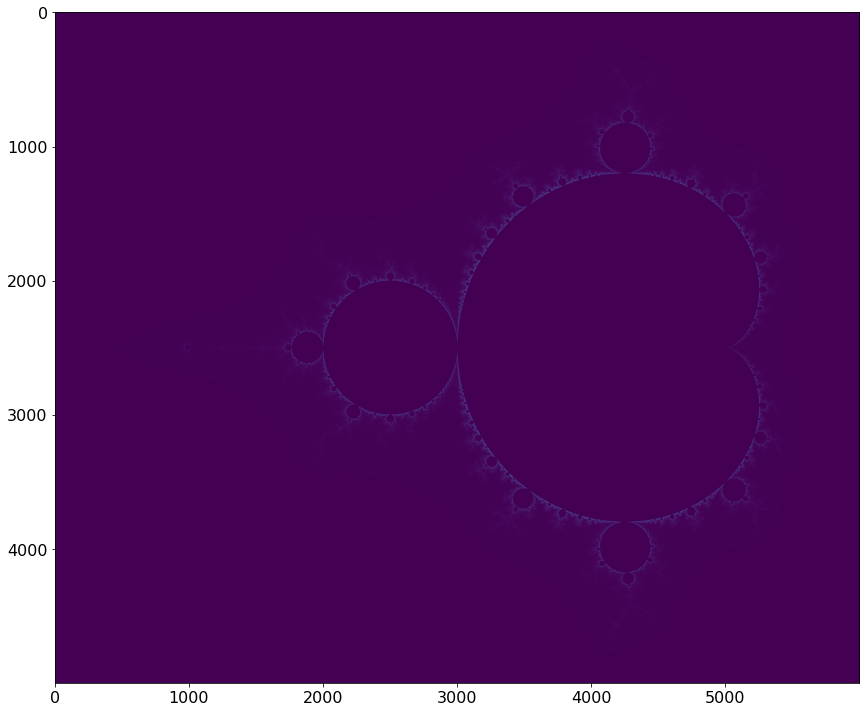

In [202]:
plt.imshow(N)
format_figure()

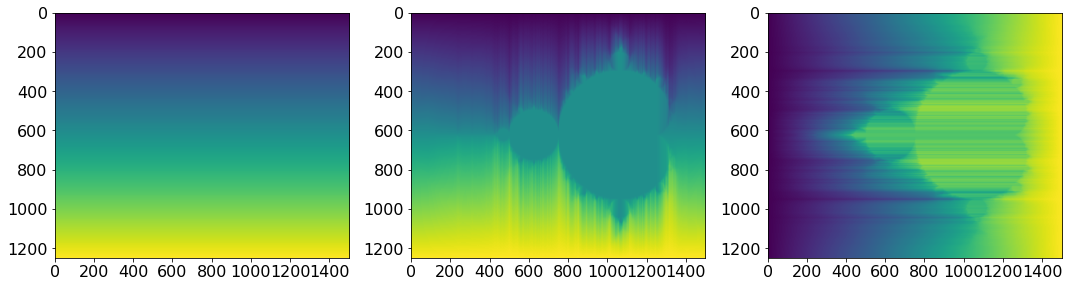

In [110]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(YY)
axs[1].imshow(np.cumsum(N, axis=0) / np.sum(N, axis = 0)[None,:])
axs[2].imshow(np.cumsum(N, axis=1) / np.sum(N, axis = 1)[:,None])

format_figure(fig, axs)

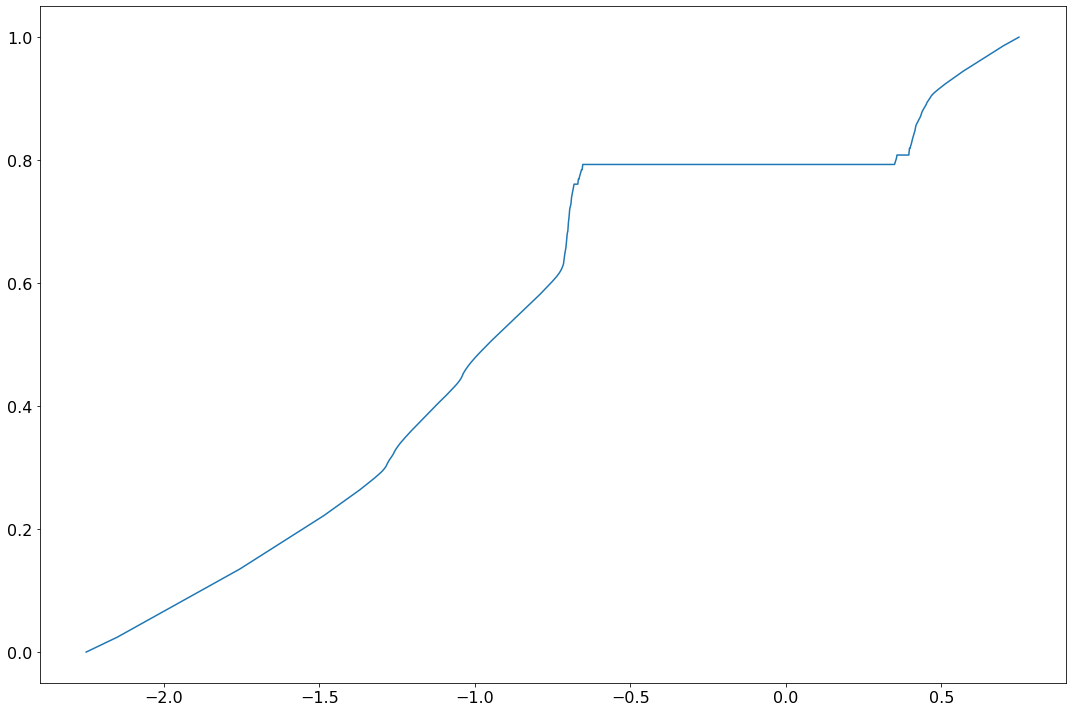

In [132]:
plt.plot(X, (np.cumsum(N, axis=1) / np.sum(N, axis=1)[:,None])[800])
# plt.plot(N[:,800])
format_figure()

In [163]:
t = np.linspace(0, 1, len(Y))
YYnew = np.array([interp1d((np.cumsum(N, axis=0) / np.sum(N, axis=0)[None,:])[:,i], Y, fill_value='extrapolate')(t) for i in range(N.shape[1])]).T

#     Ynew = f(t)
# plt.plot(Y[:20])
# plt.plot(Ynew[:20])
# format_figure(size_x=20, size_y=12)

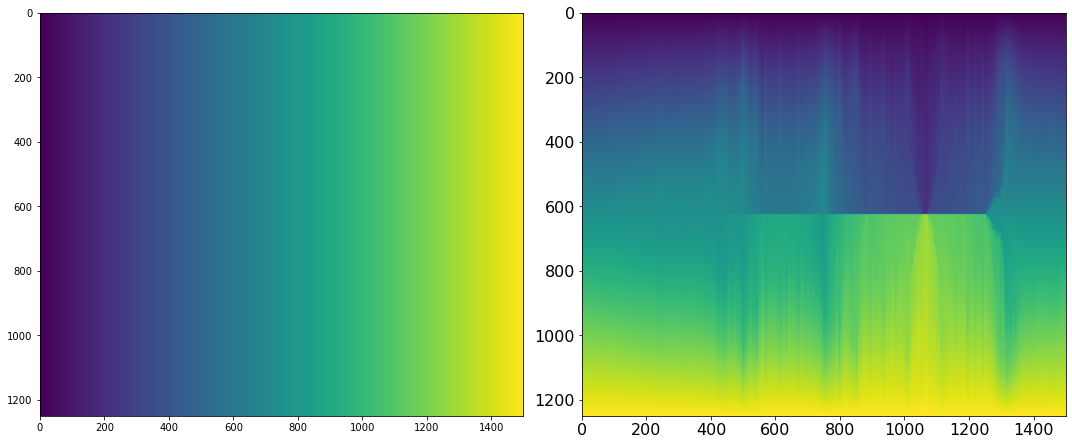

In [172]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(XX)
axs[1].imshow(YYnew)

format_figure()

In [4]:
def mandelbrot_set2(XX, YY, maxiter, horizon=2.0):
    C = XX + YY * 1j
    N = np.zeros_like(C, dtype=int)
    Z = np.zeros_like(C)
    for n in range(maxiter):
        I = abs(Z) < horizon
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N

In [129]:
_, Nnew = mandelbrot_set2(XX, np.array(YYnew).T, 200)

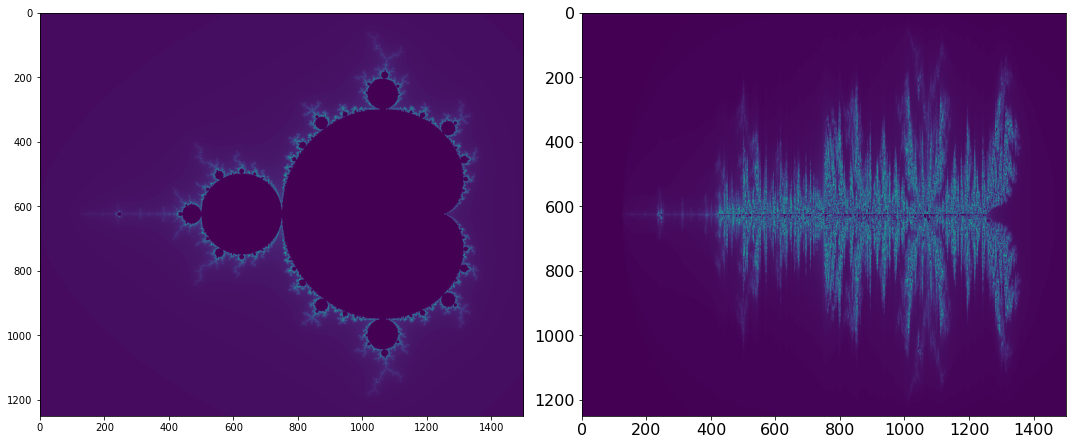

In [130]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(N)
axs[1].imshow(Nnew)

format_figure()

In [178]:
tx = np.linspace(0, 1, len(X))
ty = np.linspace(0, 1, len(Y))

YYnew2 = []
XXnew = []

for i in range(Nnew.shape[0]):
    ncol = (np.cumsum(Nnew, axis=1) / np.sum(Nnew, axis=1)[:,None])[i]
    XXnew.append(interp1d(ncol, XX[i], fill_value='extrapolate')(tx))
    YYnew2.append(interp1d(ncol, YYnew[i], fill_value='extrapolate')(tx))

XXnew = np.array(XXnew)
YYnew2 = np.array(YYnew2)

In [179]:
Nnew.shape, XX.shape, XXnew.shape, YYnew2.shape

((1250, 1500), (1250, 1500), (1250, 1500), (1250, 1500))

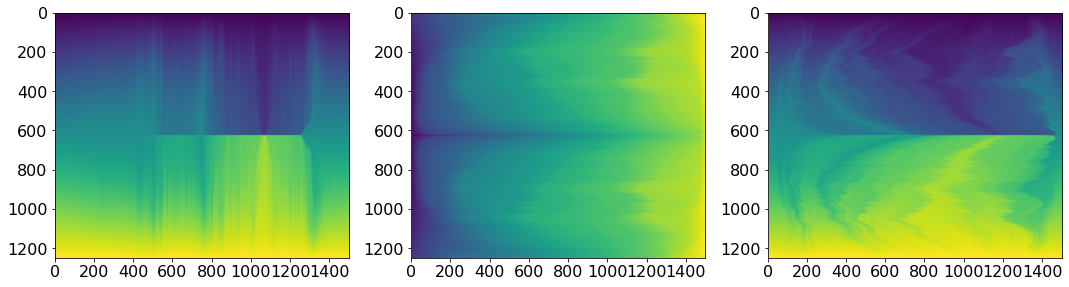

In [180]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(YYnew)
axs[1].imshow(XXnew)
axs[2].imshow(YYnew2)

format_figure(fig, axs)

In [181]:
_, Nnew2 = mandelbrot_set2(XXnew, YYnew2, 200)

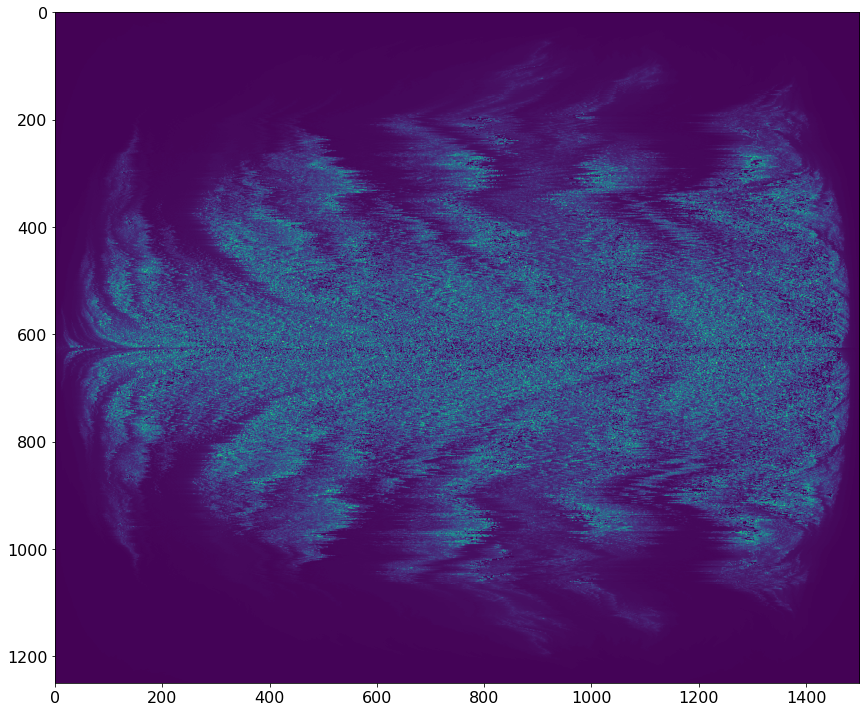

In [182]:
# fig, axs = plt.subplots(1, 2)

# axs[0].imshow(N)
# # axs[1].imshow(Nnew)
# axs[1].imshow(Nnew2)

plt.imshow(Nnew2)

format_figure()

In [5]:
xmin, xmax, xn = -2.25, 0.75, 3000 * 2
ymin, ymax, yn = -1.25, 1.25, 2500 * 2

maxiter = 2000
horizon = 2**10

X = np.linspace(xmin, xmax, xn).astype(np.float32)
Y = np.linspace(ymin, ymax, yn).astype(np.float32)

tx = np.linspace(0, 1, len(X))
ty = np.linspace(0, 1, len(Y))

XX, YY = np.meshgrid(X, Y)

starting iter 0


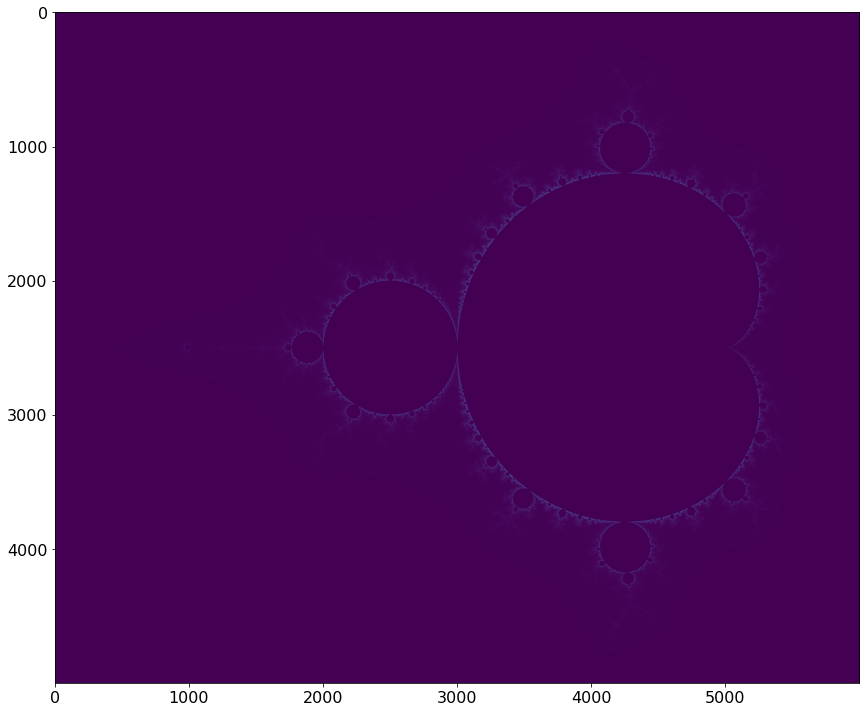

brotcalc


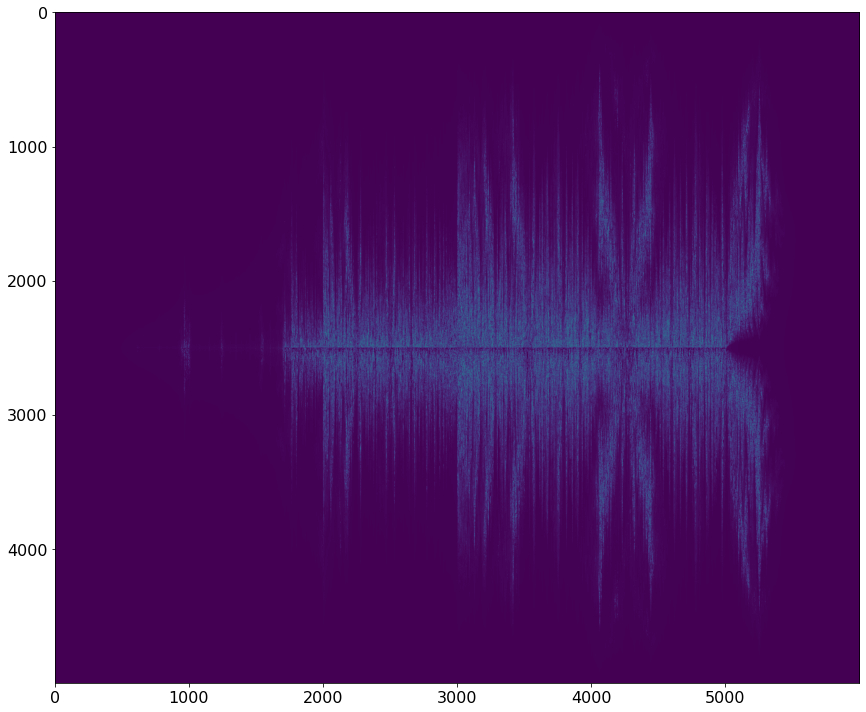

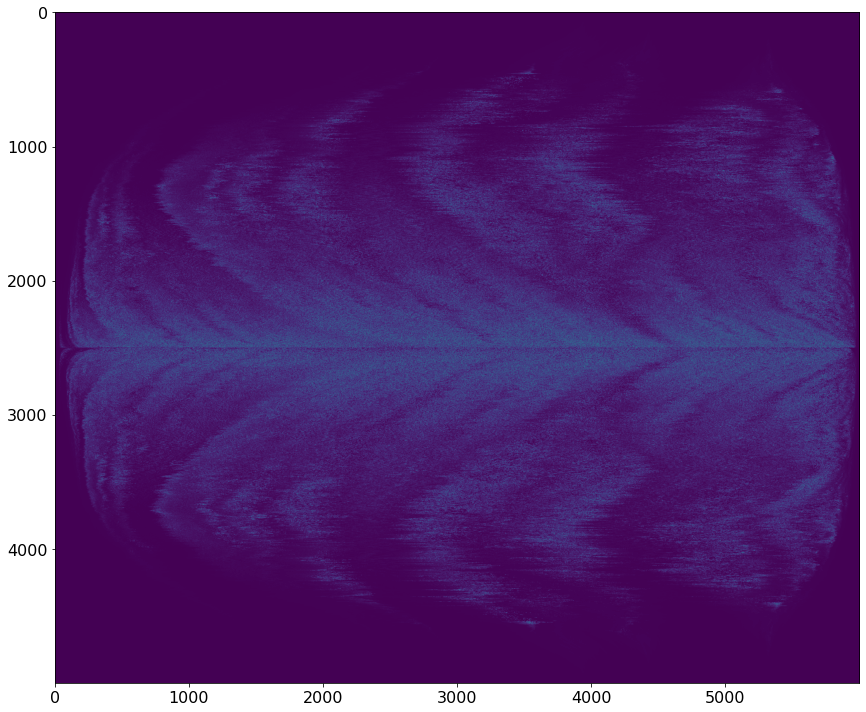

CPU times: user 20min 30s, sys: 2min 38s, total: 23min 9s
Wall time: 23min 8s


In [6]:
%%time

def deform(inp):
    cdfi, LLi, t = inp
    return interp1d(cdfi, LLi, fill_value='extrapolate')(t)

for __ in range(1):
    print('starting iter', __)
    Z, N = mandelbrot_set2(XX, YY, maxiter, horizon)
    plt.imshow(N)
    format_figure()
    plt.show()
    cdf = (np.cumsum(N, axis=0) / np.sum(N, axis=0)[None,:])
    
    XXnew = []
    YYnew = []

    print('mapping')
#     with Pool(6) as p:
#         YYnew = p.map(deform, list(zip(cdf.T, YY.T, ty)))
#         XXnew = p.map(deform, list(zip(cdf.T, XX.T, ty)))
        
    for i in range(N.shape[1]):
        YYnew.append(interp1d(cdf[:,i], YY[:,i], fill_value='extrapolate')(ty))
        XXnew.append(interp1d(cdf[:,i], XX[:,i], fill_value='extrapolate')(ty))

    XX = np.array(XXnew).T
    YY = np.array(YYnew).T
    
    print('brotcalc')
    Z, N = mandelbrot_set2(XX, YY, maxiter, horizon)
    plt.imshow(N)
    format_figure()
    plt.show()
    cdf = (np.cumsum(N, axis=1) / np.sum(N, axis=1)[:,None])

    XXnew = []
    YYnew = []

    print('mapping')
#     with Pool(6) as p:
#         YYnew = p.map(deform, list(zip(cdf, YY, tx)))
#         XXnew = p.map(deform, list(zip(cdf, XX, tx)))

    for i in range(N.shape[0]):
        XXnew.append(interp1d(cdf[i], XX[i], fill_value='extrapolate')(tx))
        YYnew.append(interp1d(cdf[i], YY[i], fill_value='extrapolate')(tx))

    XX = np.array(XXnew)
    YY = np.array(YYnew)

Z, N = mandelbrot_set2(XX, YY, maxiter, horizon)
plt.imshow(N)
format_figure()
plt.show()

np.savetxt('XX2.csv', XX, delimiter=',', fmt='%.10f')
np.savetxt('YY2.csv', YY, delimiter=',', fmt='%.10f')

starting iter 0


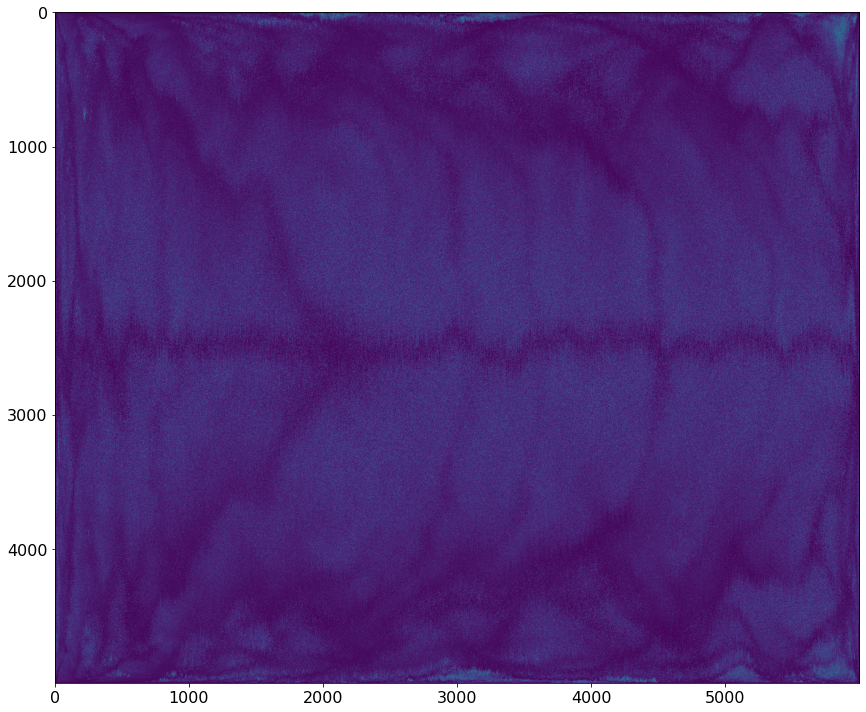

mapping


Process SpawnPoolWorker-52:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'deform' on <module '__main__' (built-in)>
Process SpawnPoolWorker-49:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv

Process SpawnPoolWorker-61:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'deform' on <module '__main__' (built-in)>
Process SpawnPoolWorker-62:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv

Process SpawnPoolWorker-75:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-77:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/myenv38/lib/python3.8/multiprocessing/process.py", line 31

KeyboardInterrupt: 

In [226]:
%%time

def deform(inp):
    cdfi, LLi, t = inp
    return interp1d(cdfi, LLi, fill_value='extrapolate')(t)

for __ in range(5):
    print('starting iter', __)
#     Z, N = mandelbrot_set2(XX, YY, maxiter, horizon)
    plt.imshow(N)
    format_figure()
    plt.show()
    cdf = (np.cumsum(N, axis=0) / np.sum(N, axis=0)[None,:])
    
    XXnew = []
    YYnew = []

    print('mapping')
    with Pool(6) as p:
        YYnew = p.map(deform, list(zip(cdf.T, YY.T, ty)))
        XXnew = p.map(deform, list(zip(cdf.T, XX.T, ty)))
        
#     for i in range(N.shape[1]):
#         YYnew.append(interp1d(cdf[:,i], YY[:,i], fill_value='extrapolate')(ty))
#         XXnew.append(interp1d(cdf[:,i], XX[:,i], fill_value='extrapolate')(ty))

    XX = np.array(XXnew).T
    YY = np.array(YYnew).T
    
    print('brotcalc')
    Z, N = mandelbrot_set2(XX, YY, maxiter, horizon)
    plt.imshow(N)
    format_figure()
    plt.show()
    cdf = (np.cumsum(N, axis=1) / np.sum(N, axis=1)[:,None])

    XXnew = []
    YYnew = []

    print('mapping')
    with Pool(6) as p:
        YYnew = p.map(deform, list(zip(cdf, YY, tx)))
        XXnew = p.map(deform, list(zip(cdf, XX, tx)))

#     for i in range(N.shape[0]):
#         XXnew.append(interp1d(cdf[i], XX[i], fill_value='extrapolate')(tx))
#         YYnew.append(interp1d(cdf[i], YY[i], fill_value='extrapolate')(tx))

    XX = np.array(XXnew)
    YY = np.array(YYnew)

    Z, N = mandelbrot_set2(XX, YY, maxiter, horizon)
    plt.imshow(N)
    format_figure()
    plt.show()
    
    np.savetxt('XX_%d.csv' % (__ + 2), XX, delimiter=',', fmt='%.10f')
    np.savetxt('YY_%d.csv' % (__ + 2), YY, delimiter=',', fmt='%.10f')

In [206]:
np.savetxt('XX.csv', XX, delimiter=',', fmt='%.10f')
np.savetxt('YY.csv', YY, delimiter=',', fmt='%.10f')

In [212]:
M = N + 1 - np.log(np.log(np.sqrt(np.abs(Z))) / np.log(horizon)) / np.log(2)

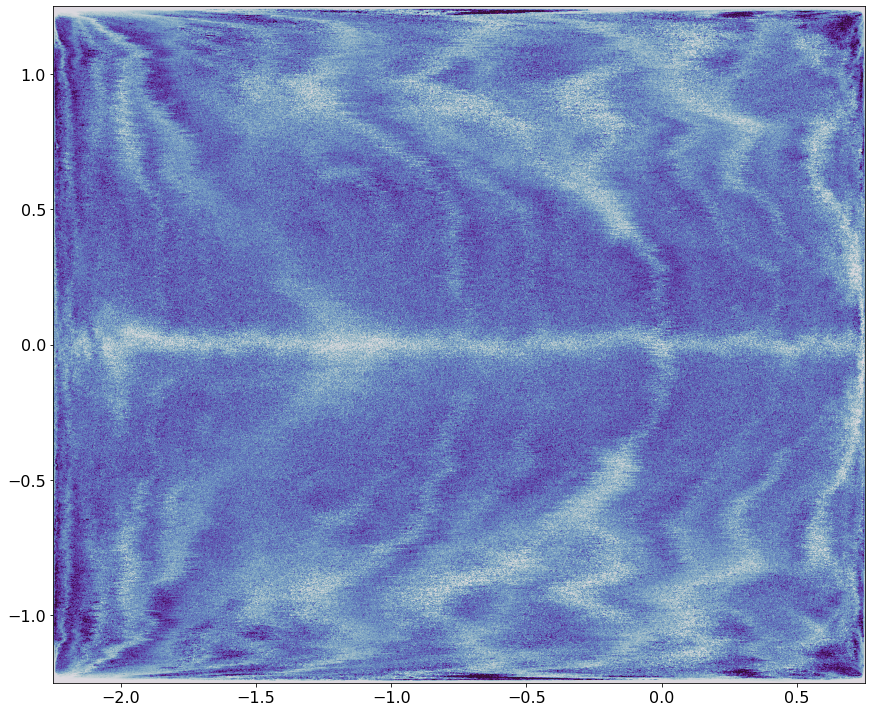

In [213]:
index = np.mod(M.astype(int), 384)
plt.imshow(index, cmap='twilight', extent=[-2.25,0.75, -1.25,1.25])
format_figure()
plt.show()

In [217]:
xc, yc = (np.median(XX), np.median(YY))
print(xc, yc)

distance = np.sqrt(np.power(XX - xc, 2) + np.power(YY - yc, 2))

-0.4046794398598481 0.009436758966956544


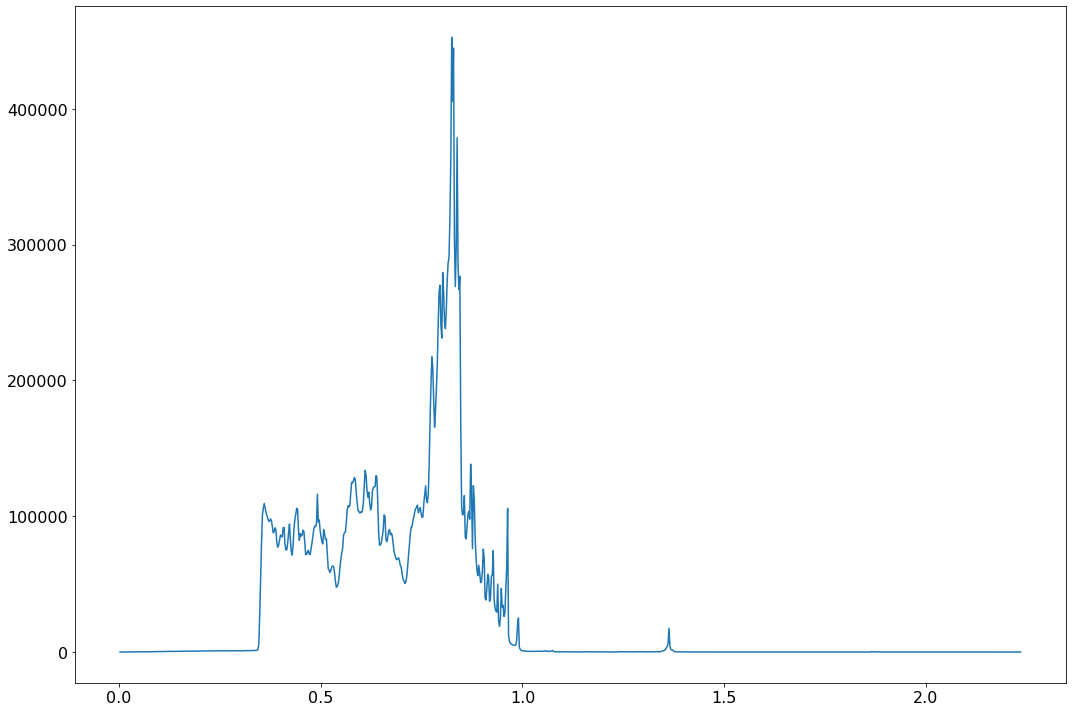

In [219]:
h, b = np.histogram(distance, bins=1000)
b = (b[:-1] + b[1:]) / 2
plt.plot(b,h)
format_figure()